# Code to convert real-world soft pendulum measurements to hdf5 data structure for DKN learning

In [1]:
%matplotlib notebook

In [2]:
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
dir = "20220309_easy"

with open('../src/'+dir+'/standup_1', 'rb') as fin:
    data1 = pickle.load(fin, encoding='latin1')
    
with open('../src/'+dir+'/standup_2', 'rb') as fin:
    data2 = pickle.load(fin, encoding='latin1')
    
with open('../src/'+dir+'/osc_1', 'rb') as fin:
    data3 = pickle.load(fin, encoding='latin1')

with open('../src/'+dir+'/osc_2', 'rb') as fin:
    data4 = pickle.load(fin, encoding='latin1')

    
data = np.concatenate([data3,data4,data1,data2])

In [4]:
#Starting from the left column, the values are [x,dx,th,dth,u].

p = data[:,0]
dp = data[:,1]
theta = data[:,2]
dtheta_raw = data[:,3]
dtheta = data[:,4]

<IPython.core.display.Javascript object>


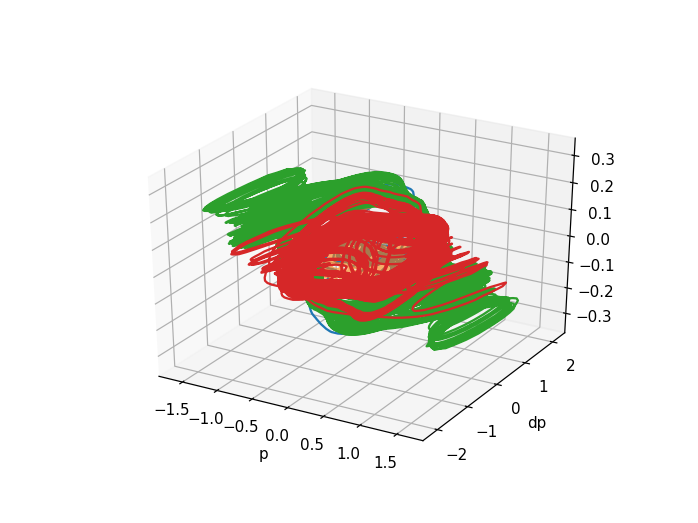

Text(0.5, 0, 'dp')

In [5]:

# visualise the data, and the number of indices to drop
Drop_index = 1 
fig = plt.figure()
ax = plt.axes(projection='3d')
#plt.plot(p,dp,theta,'.')
plt.plot(data1[:,0],data1[:,1],data1[:,2])
plt.plot(data2[:,0],data2[:,1],data2[:,2],alpha=0.6)
plt.plot(data3[:,0],data3[:,1],data3[:,2])
plt.plot(data4[:,0],data4[:,1],data4[:,2])
plt.xlabel('p')
plt.ylabel('dp')

In [6]:
# print initial conditions
print(p[0],dp[0],theta[0])

1.1656895882641236 -0.05160151399221391 -9.566942323857575e-05


In [7]:
import h5py
import sys
sys.path.append('../fromServer_Keras-HDF5-ImageDataGenerator/')

#sys.path.append('/home/rl-gtune/Documents/Research/GitRepos/libraries/Keras-HDF5-ImageDataGenerator/')
from h5imagegenerator.generator import HDF5ImageGenerator

2022-03-30 17:04:43.080061: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.


In [8]:
# concate data to matrix
X_states = np.array([p[Drop_index:],dp[Drop_index:],theta[Drop_index:],dtheta[Drop_index:]]).T

# Split into trajectories of fixed length (for one step, step history=2)
history = 51
X_states = np.array([X_states[i:i+history] for i in range(0,X_states.shape[0]-history)])
# np.random.shuffle(X_states)

X_states.shape

(143948, 51, 4)

<IPython.core.display.Javascript object>


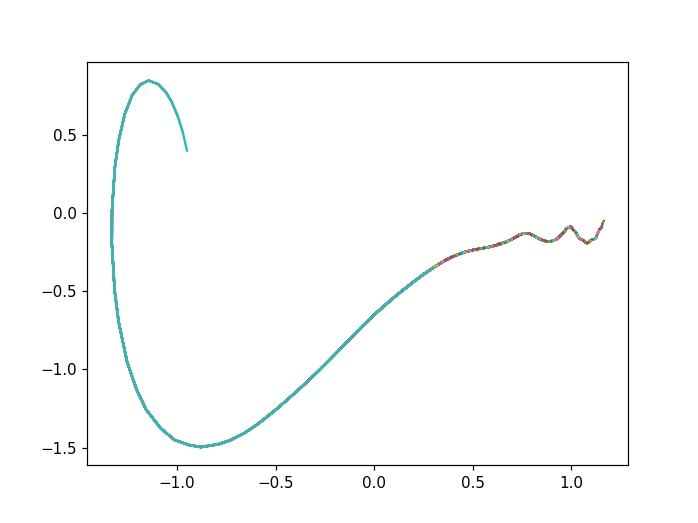

In [9]:
# Plot some examples to see if the history works
fig = plt.figure()
for i in range(100):
    plt.plot(X_states[i,:,0],X_states[i,:,1])

In [10]:
# Define datasize sizes
N = X_states.shape[0]
train_N = int(N*0.7)
valid_N = int(N*0.1)
test_N = N - train_N - valid_N

In [11]:
print(train_N,test_N,valid_N)

100763 28791 14394


In [12]:
# Randomly split into train/test/valid
indices = np.array(range(N))
indices = np.random.permutation(indices)
train_indices = indices[:train_N]
valid_indices = indices[train_N:train_N+valid_N]
test_indices = indices[train_N+valid_N:]

In [13]:
# Save to file
def save_state_to_file(name,X):
    f = h5py.File("../src/"+dir+"/{}.hdf5".format(name), 'a')

    # Create the dataset at first
    f.create_dataset("state_t", data=X[:,:-1])
    f.create_dataset("state_tp1", data=X[:,1:])

save_state_to_file('train',X_states[train_indices])   
save_state_to_file('valid',X_states[valid_indices]) 
save_state_to_file('test',X_states[test_indices]) 

<IPython.core.display.Javascript object>


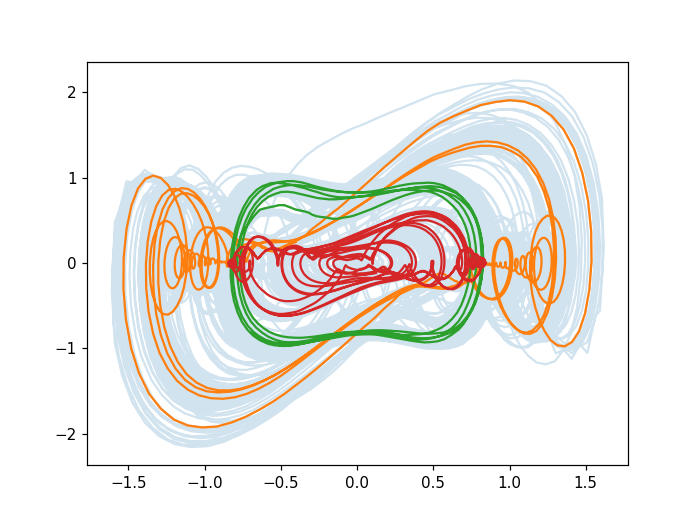

In [14]:
# extract, small,mid,long exemplars

#small
x_as = 10000
x_ae = 12000

#mid
x_bs = 69500
x_be = 70000

#long
x_cs = 130000
x_ce = 135000

fig = plt.figure()
plt.plot(X_states[:,-1,0],X_states[:,-1,1],alpha=0.2)
plt.plot(X_states[x_as:x_ae,-1,0],X_states[x_as:x_ae,-1,1])
plt.plot(X_states[x_bs:x_be,-1,0],X_states[x_bs:x_be,-1,1])
plt.plot(X_states[x_cs:x_ce,-1,0],X_states[x_cs:x_ce,-1,1])
#plt.colorbar()

# Save to file incrementally (for very large datasets)

def save_long_traj(X_states,name,N):
    f = h5py.File("../src/"+dir+"/{}.hdf5".format(name), 'a')
    f.create_dataset("state_t", data=X_states[:,:N-1], chunks=True, maxshape=(None,N-1,X_states.shape[2]))
    f.create_dataset("state_tp1", data=X_states[:,1:], chunks=True, maxshape=(None,N-1,X_states.shape[2]))
    f.close()

save_long_traj(X_states[x_as:x_ae],'long',history)   
save_long_traj(X_states[x_bs:x_be],'mid',history) 
save_long_traj(X_states[x_cs:x_ce],'small',history) 
